# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.


In [182]:
!pip install pycodestyle pycodestyle_magic flake8

  Using cached https://files.pythonhosted.org/packages/0e/0c/04a353e104d2f324f8ee5f4b32012618c1c86dd79e52a433b64fceed511b/pycodestyle-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/45/9f0f65ab41d816bed8d37c32e61d2ff49f0b03ef2278ee15aeb6fb8e1ec5/pycodestyle_magic-0.2.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/76/b915bd28976068a9843bf836b789794aa4a8eb13338b23581005cd9177c0/flake8-3.7.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/84/f2/ed0ffb887f8138a8fe5a621b8c0bb9598bfb3989e029f6c6a85ee66628ee/pyflakes-2.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/89/479dc97e18549e21354893e4ee4ef36db1d237534982482c3681ee6e7b57/mccabe-0.6.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ac/c6/44694103f8c221443ee6b0041f69e2740d89a25641e62fb4f2ee568f2f9c/entrypoints-0.3-py2.py3-none-any.whl
tensorflow 1.3.0 requires tensorflow-tensor

In [183]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [250]:
#%%pycodestyle
import ibmos2spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, avg, lit
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [185]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-0ff040fe-cb91-495b-b5f8-f21d8eb27227',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'biMc646WNN-SCcy4VbylXc1SN3n4_zArhejYXR_KMf0I'
}

configuration_name = 'os_bcf6f3845ac342f0bfda9106dad790cb_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [186]:
df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json',
                                    'sparkify-donotdelete-pr-nxvkpzudbrgtqs'))
df_data_1.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

### Clean Dataset

In [187]:
print(df_data_1.count())

543705


In [188]:
df_data_1 = df_data_1.where(col('auth') != 'Logged Out')

In [189]:
print(df_data_1.count())
df_data_1 = df_data_1.dropna(subset=["userId", "sessionId"])
print(df_data_1.count())

528099
528099


In [190]:
df_data_1.where(col('userId').isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [191]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [192]:
df_data_1.describe().show()

+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|     auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|   528099|   528005|528005|            528099|  528005|            432877|528099|          528005|528099| 528099|              

In [193]:
df_data_1.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772758|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [194]:
df_data_1.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            528099|
|   mean|2042.8019689490038|
| stddev|1434.0632907551988|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [195]:
df_data_1.count()

528099

In [196]:
df_data_1.select("page").dropDuplicates().sort("page").show(100)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+




### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [197]:
get_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0)

In [198]:
df_churn = df_data_1.withColumn("churn", get_churn("page"))

In [199]:
df_churn.filter(df_churn.churn == 1).count()

99

In [200]:
df_churn.filter(df_churn.churn == 0).count()

528000


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Free/Paid distribution

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


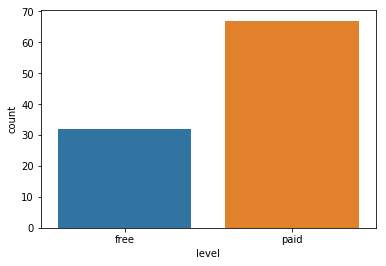

In [201]:
df_level = df_churn.filter(df_churn.churn == 1)
df_level = df_level.groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_level)

#### Songs per hour

In [202]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df_churn = df_churn.withColumn("hour", get_hour(df_churn.ts))

In [203]:
songs_in_hour = df_churn.filter(df_churn.page == "NextSong")\
    .groupby(df_churn.hour).count()

Text(0,0.5,'Songs played')

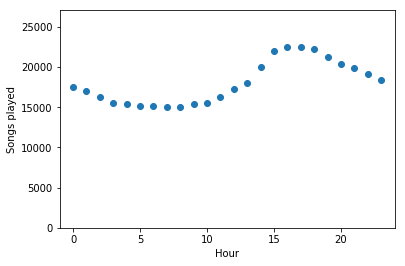

In [204]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")

In [205]:
df_cancelled = df_churn.filter(df_churn.churn == 1)
df_cancelled.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: string, hour: string]

In [206]:
cancelled_userIds = df_cancelled.select("userId").dropDuplicates().collect()

In [207]:
cancelled_userIds = [item.userId for item in cancelled_userIds]

In [208]:
churned_user_records = df_churn.filter(df_churn.userId.isin(cancelled_userIds))

In [209]:
songs_in_hour_churned = churned_user_records.filter(
    df_churn.page == "NextSong").groupby(churned_user_records.hour).count()

In [210]:
churned_user_records.count()

103646

Text(0,0.5,'Songs played')

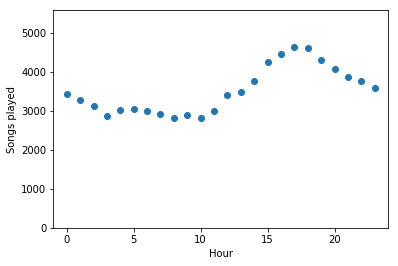

In [211]:
songs_in_hour_churned_pd = songs_in_hour_churned.toPandas()
songs_in_hour_churned_pd.hour = pd.to_numeric(songs_in_hour_churned_pd.hour)
plt.scatter(songs_in_hour_churned_pd["hour"],
            songs_in_hour_churned_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_churned_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")

In [212]:
df_not_cancelled = df_churn.filter(df_churn.churn == 0)
df_not_cancelled.cache()
not_cancelled_userIds = df_not_cancelled.select("userId")\
    .dropDuplicates().collect()

In [213]:
not_cancelled_userIds = [item.userId for item in not_cancelled_userIds]
not_churned_user_records = df_churn\
    .filter(df_churn.userId.isin(not_cancelled_userIds))
songs_in_hour_not_churned = not_churned_user_records\
    .filter(df_churn.page == "NextSong")\
    .groupby(not_churned_user_records.hour).count()

Text(0,0.5,'Songs played')

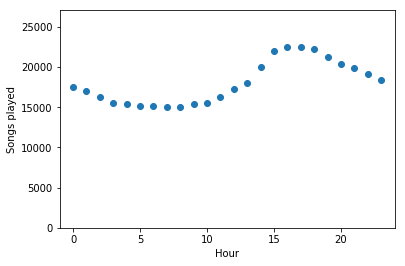

In [214]:
songs_in_hour_not_churned_pd = songs_in_hour_not_churned.toPandas()
songs_in_hour_not_churned_pd.hour = pd.to_numeric(
    songs_in_hour_not_churned_pd.hour)
plt.scatter(songs_in_hour_not_churned_pd["hour"],
            songs_in_hour_not_churned_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_not_churned_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")

Text(0,0.5,'Songs played')

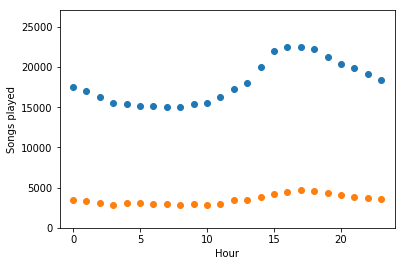

In [215]:
plt.scatter(songs_in_hour_not_churned_pd["hour"],
            songs_in_hour_not_churned_pd["count"])
plt.scatter(songs_in_hour_churned_pd["hour"],
            songs_in_hour_churned_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_not_churned_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")

#### Songs played

In [216]:
songs_played_churned_user_records = churned_user_records\
    .where(col('song') != 'null').groupby("userId").agg(count(col('song')))
songs_played_churned_user_records = songs_played_churned_user_records\
    .agg(avg(col("count(song)")))
songs_played_churned_user_records.show()

+-----------------+
| avg(count(song))|
+-----------------+
|852.1111111111111|
+-----------------+



In [217]:
songs_played_not_churned_user_records = not_churned_user_records\
    .where(col('song') != 'null').groupby("userId").agg(count(col('song')))
songs_played_not_churned_user_records = songs_played_not_churned_user_records\
    .agg(avg(col("count(song)")))
songs_played_not_churned_user_records.show()

+-----------------+
| avg(count(song))|
+-----------------+
|966.2433035714286|
+-----------------+



#### Thumbs Down

In [218]:
thumbs_down = df_churn.where(df_churn.page == 'Thumbs Down')\
    .groupby("userId").agg(count(col('page')))
thumbs_down.show()

+------+-----------+
|userId|count(page)|
+------+-----------+
|100010|          3|
|200002|          5|
|   125|          1|
|   124|         15|
|    51|          1|
|     7|          4|
|200037|          3|
|   205|         10|
|   272|          4|
|   282|         29|
|   232|         17|
|    15|         16|
|    54|          7|
|   234|         22|
|200043|         22|
|   154|          2|
|   132|          1|
|100014|          3|
|300027|          5|
|   200|          2|
+------+-----------+
only showing top 20 rows



In [219]:
churned_thumbs_down = churned_user_records.where(
    churned_user_records.page == 'Thumbs Down').groupby("userId")\
    .agg(count(col('page')))
churned_thumbs_down.show()

+------+-----------+
|userId|count(page)|
+------+-----------+
|100010|          3|
|200002|          5|
|   124|         15|
|    51|          1|
|200037|          3|
|    54|          7|
|   234|         22|
|100014|          3|
|   154|          2|
|   132|          1|
|   200|          2|
|    11|          1|
|    34|         11|
|   162|         15|
|200013|          4|
|    28|          7|
|    85|         33|
|    16|          7|
|   187|          3|
|   188|         22|
+------+-----------+
only showing top 20 rows



In [220]:
not_churned_thumbs_down = not_churned_user_records.where(
    not_churned_user_records.page == 'Thumbs Down')\
    .groupby("userId").agg(count(col('page')))
not_churned_thumbs_down.show()

+------+-----------+
|userId|count(page)|
+------+-----------+
|100010|          3|
|200002|          5|
|   125|          1|
|   124|         15|
|    51|          1|
|     7|          4|
|200037|          3|
|   205|         10|
|   272|          4|
|   282|         29|
|   232|         17|
|    15|         16|
|    54|          7|
|   234|         22|
|200043|         22|
|   154|          2|
|   132|          1|
|100014|          3|
|   200|          2|
|300027|          5|
+------+-----------+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [221]:
df_features = df_churn

In [222]:
songs_played = df_features.where(col('song') != 'null')\
    .groupby("userId").agg(count(col('song')))
df_features = df_features.join(songs_played, "userId")

In [223]:
thumbs_down = df_features.where(df_features.page == 'Thumbs Down')\
    .groupby("userId").agg(count(col('page')))
df_features = df_features.join(thumbs_down, "userId")

In [224]:
df_features.describe()

DataFrame[summary: string, userId: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, churn: string, hour: string, count(song): string, count(page): string]

In [225]:
df_features.persist()

DataFrame[userId: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, churn: string, hour: string, count(song): bigint, count(page): bigint]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Metrics
The metrics used for these models are the test accuracy and F1 score.

The test accuracy is used to see how well the model would do if we gave it test data that it had not seen before by getting a percentage of the successful churn classifications made.

The F1 score is also used as it can be very helpful when the cost of false positives and false negatives aren’t the same. For example, if a user that isn’t likely to cancel their account is classified as likely to cancel their account (false positive) the impact isn’t severe as a company may try to improve the satisfaction of a user who is already happy. In the opposite case, a user likely to cancel their account is classified as unlikely to cancel (false negative) then they may be overlooked completely and that user may cancel their account without a company making an effort to improve their experience.

In [226]:
df_features = df_features.withColumn("churn",
                                     df_features["churn"].cast("double"))

In [227]:
columns = ['churn', 'count(song)', 'count(page)']
assembler = VectorAssembler(inputCols=columns, outputCol="NumFeatures")
data = assembler.transform(df_features)

In [228]:
scaler = StandardScaler(inputCol="NumFeatures",
                        outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [229]:
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [230]:
lr = LinearRegression(maxIter=5, regParam=0.0, fitIntercept=False,
                      solver="normal")

In [231]:
pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [232]:
data_lr = train.select(col("count(page)").alias("label"),
                       col("NumFeatures").alias("features"))

In [233]:
cvModel = crossval.fit(data_lr)

In [234]:
cvModel.avgMetrics

[0.6801207596054578, 0.0]

In [235]:
val_lr = test.select(col("count(page)").alias("label"),
                     col("NumFeatures").alias("features"))
results = cvModel.transform(val_lr)

In [236]:
print(results.filter(results.label == results.prediction).count())
print(results.count())

50398
104244


In [237]:
52121/val_lr.count()

0.4999904071217528

#### KMeans

In [238]:
kmeans = KMeans().setParams(featuresCol="NumFeatures",
                            predictionCol="KmeansGroup", k=5, seed=42)
kmeans_model = kmeans.fit(train)
df_kmeans = kmeans_model.transform(test)

In [239]:
df_kmeans.groupby("KmeansGroup").agg(
    avg(col("count(song)").alias("Num of Songs")),
    avg(col("count(page)").alias("Thumbs Down"))).show()

+-----------+----------------------------------+---------------------------------+
|KmeansGroup|avg(count(song) AS `Num of Songs`)|avg(count(page) AS `Thumbs Down`)|
+-----------+----------------------------------+---------------------------------+
|          1|                 5057.508304662475|               48.779689168347375|
|          3|                            8177.0|                             80.0|
|          4|                1925.8876810475278|               21.595009419103796|
|          2|                 774.6793492874428|               10.246598547996774|
|          0|                3251.0999811118804|               34.817729648051376|
+-----------+----------------------------------+---------------------------------+



#### Logistic Regression

In [240]:
model = LogisticRegression()

In [241]:
logistic_regression = model.fit(data_lr)

In [245]:
logistic_regression_results = logistic_regression.transform(val_lr)

In [256]:
def print_results(results):
    accuracy_evaluator = MulticlassClassificationEvaluator(
        metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(
        results.select(col('label'), col('prediction')))
    print(accuracy)
    f1 = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1.evaluate(
        results.select(col('label'), col('prediction')))
    print(f1_score)

In [248]:
print_results(logistic_regression_results)

0.5229941291585127
0.47356306245271246


#### Random Forest

In [259]:
model_rf = RandomForestClassifier()
random_forest = model_rf.fit(data_lr)
random_forest_results = random_forest.transform(val_lr)
print_results(random_forest_results)

0.6614865124131845
0.5941034076288182


#### Cross Validator

In [293]:
model_rf = RandomForestClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(model_rf.numTrees, [10, 20, 40]) \
    .addGrid(model_rf.maxDepth, [5, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=model_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
                              metricName='f1'),
                          numFolds=3)

In [294]:
random_forest_cross_val = crossval.fit(data_lr)
random_forest_cross_val_results = random_forest_cross_val.transform(val_lr)
print_results(random_forest_cross_val_results)

0.9088100993822187
0.8966030196744592


In [295]:
random_forest_cross_val.avgMetrics

[0.6106675870884074,
 0.8962159190050045,
 0.8986222274621753,
 0.5798364489653189,
 0.8920385470236655,
 0.8983193023434037,
 0.6450088073466177,
 0.8924893026345748,
 0.8979620271586326]

In [296]:
random_forest_cross_val.bestModel._java_obj.getNumTrees()

10

In [297]:
random_forest_cross_val.bestModel._java_obj.getMaxDepth()

20

## Improvements
A first step that could be taken to improve the results gathered is extending the train and test set to the full dataset as the IBM Watson Studio free trial does not have access to the full Sparkify dataset. The larger dataset could significantly improve results.